### Importing required libraries

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Flatten,Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle
import warnings
warnings.filterwarnings('ignore')

In [21]:
#Loading dataset
df=pd.read_csv("cleaned.csv")

In [3]:
df.head(5)

,reviewText,pos_score,neg_score,sentiment
0,vital accessory player love retractable dont l...,0.591,0.000,0
1,case fit well side volume button dont work top...,0.205,0.259,1
2,iphone broke bought use iphone come whenever u...,0.137,0.236,1
3,needed transmitter iphone jobthings dont like ...,0.000,0.363,1
4,cheap knock dont buy expecting one like one ca...,0.185,0.000,0


In [26]:
#some of them are not in string format so converting all of them to str
df['reviewText'] = df['reviewText'].apply(str)

In [27]:
#verifying the changes made
all(df['reviewText'].apply(lambda x: type(x)) == str)

True

#### visualizing the sentiment counts

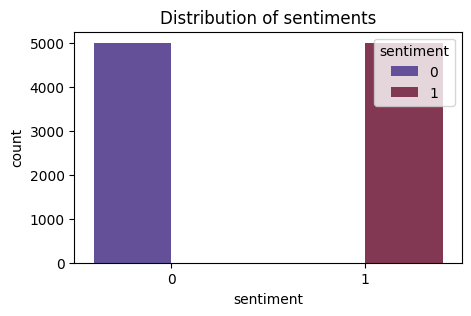

In [47]:
plt.figure(figsize=(5,3))
plt.title('Distribution of sentiments')
ax = sns.countplot(data = df, x="sentiment", order=df["sentiment"].value_counts().index,hue = "sentiment",palette='twilight') 
plt.show()

In [29]:
# visualizing the frequent words
all_words = " ".join([sentence for sentence in df['reviewText']])

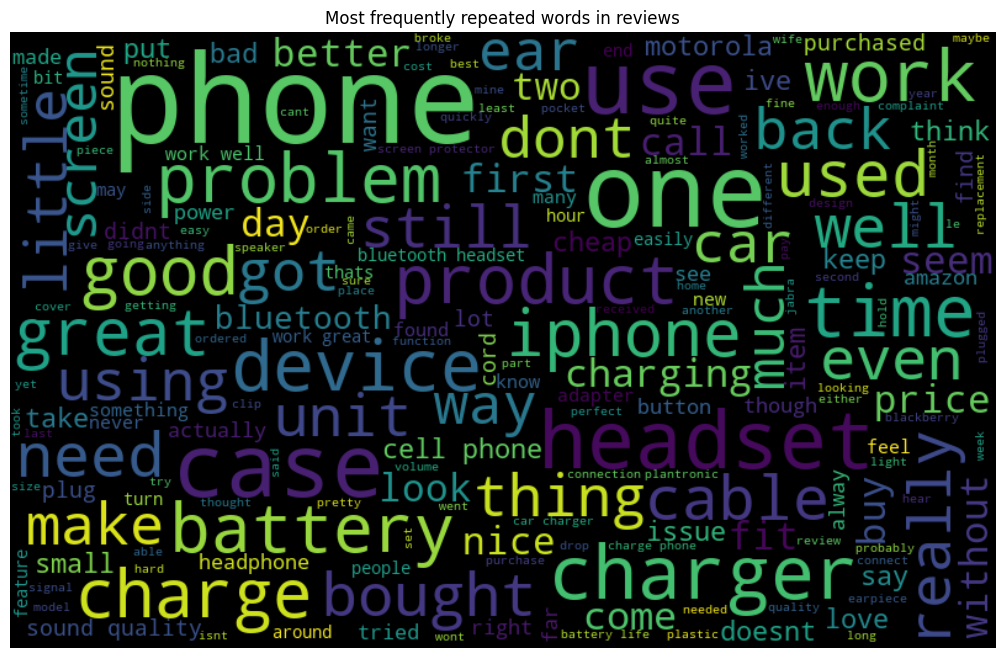

In [30]:
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plotting the graph
plt.figure(figsize=(15,8))
plt.title("Most frequently repeated words in reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

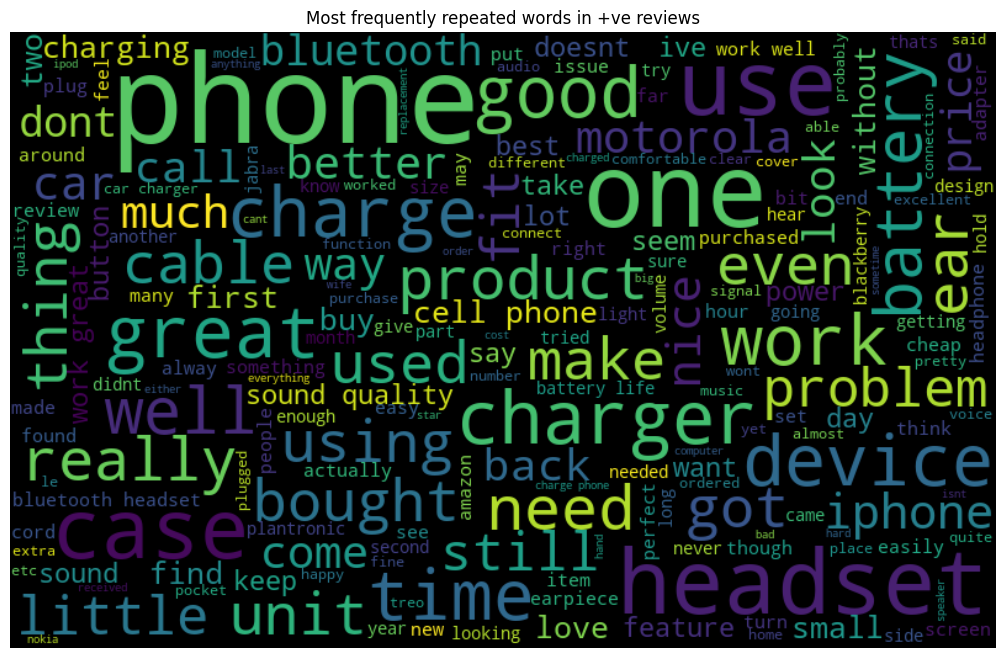

In [31]:
# frequent words visualization for +ve reviews
positive_words = " ".join([sentence for sentence in df['reviewText'][df['sentiment']==0]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(positive_words)

# plotting the graph
plt.figure(figsize=(15,8))
plt.title("Most frequently repeated words in +ve reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

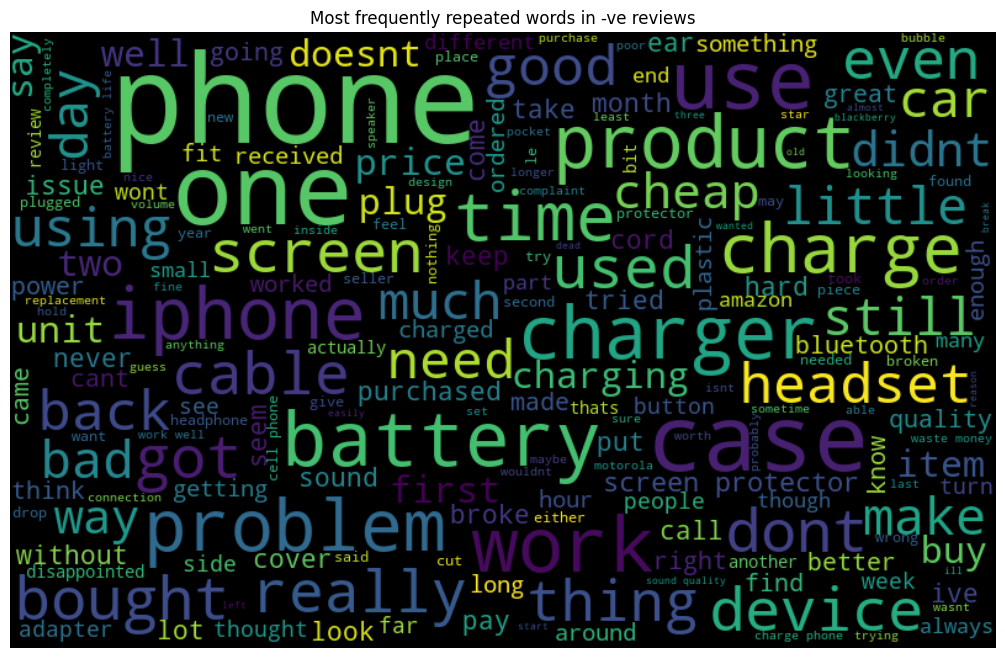

In [32]:
# frequent words visualization for -ve reviews
negative_words = " ".join([sentence for sentence in df['reviewText'][df['sentiment']==1]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(negative_words)

# plotting the graph
plt.figure(figsize=(15,8))
plt.title("Most frequently repeated words in -ve reviews")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
#separating independent and dependent variables
texts = df['reviewText'].values
labels=df["sentiment"].values

In [11]:
#dumping the entire reviews on a pickle file for later purpose
pickle.dump(texts,open('texts.pkl','wb'))

In [34]:
#checking some random user reviews 
texts[0]

'vital accessory player love retractable dont long cable getting tangle thing great price well free shipping'

In [35]:
#fixing the vocab size,input length,embedding dimension after many trail and error considering my resources.
vocab_size=10000
sent_len=250
emb_dim=20

In [36]:
# Pre-processing the text data to fit in to the model
tokenizer = Tokenizer(num_words=vocab_size)

#basically a onehot encodding of the texts
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index=tokenizer.word_index

In [37]:
sequences[0]

[3811, 513, 397, 113, 963, 18, 68, 23, 154, 2568, 39, 14, 37, 17, 358, 374]

In [38]:
# Padding the sequences to the same length
X = pad_sequences(sequences,padding="post",maxlen=sent_len)
y = labels

In [40]:
print(f'shape of X before splitting {X.shape}')
print(f'shape of Y before splitting {y.shape}')

shape of X is (10000, 250)
shape of Y is (10000,)


In [42]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
print("Shape after splitting")
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

Shape after splitting
(8000, 250) (8000,)
(2000, 250) (2000,)


In [16]:
#initializing and tunning optimizer based on many trail and error
adam=Adam(learning_rate=0.001)

### Model Building

In [17]:
model = Sequential()
#embedding layer
model.add(Embedding(vocab_size,emb_dim, input_length=X.shape[1]))
#lstm layer
model.add(Bidirectional(LSTM(16,dropout=0.2)))
#fully connected layer
model.add(Dense(1, activation='sigmoid'))

# Compiling and training the model
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

# Evaluating the model on test data
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Epoch 1/5
250/250 [==============================] - 14s 45ms/step - loss: 0.5717 - accuracy: 0.7050 - val_loss: 0.4045 - val_accuracy: 0.8340
Epoch 2/5
250/250 [==============================] - 10s 41ms/step - loss: 0.4110 - accuracy: 0.8356 - val_loss: 0.3912 - val_accuracy: 0.8430
Epoch 3/5
250/250 [==============================] - 10s 41ms/step - loss: 0.2627 - accuracy: 0.8992 - val_loss: 0.3924 - val_accuracy: 0.8340
Epoch 4/5
250/250 [==============================] - 10s 41ms/step - loss: 0.1972 - accuracy: 0.9280 - val_loss: 0.4051 - val_accuracy: 0.8410
Epoch 5/5
250/250 [==============================] - 10s 41ms/step - loss: 0.1536 - accuracy: 0.9486 - val_loss: 0.4459 - val_accuracy: 0.8445
Accuracy: 84.45%


#### Evaluating the model on different metrics

In [19]:
# Generating predictions on the test data
y_pred = model.predict(X_test)

# Converting the predictions to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Computing the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_binary)
print(confusion_mat)


[[826 142]
 [169 863]]


In [20]:
# Printing the classification report
print(classification_report(y_test, y_pred_binary))


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       968
           1       0.86      0.84      0.85      1032

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



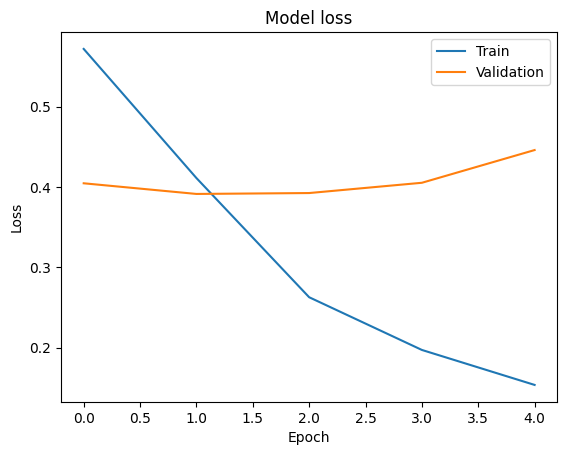

In [22]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

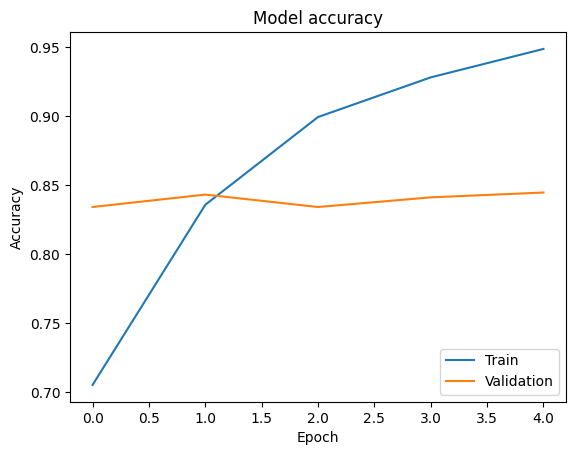

In [23]:
# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### saving the model

In [18]:
model.save("sentiment_model.h5")